# Data exploration

Visual exploration of the input data.

In [33]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
from reco.plotting import plot_tracksters, get_event_window
from reco.distance import get_z_map, apply_map

%matplotlib inline
plt.style.use('seaborn-whitegrid')

ds_name = "MultiParticle"
file_name = "new_ntuples_15163313_7.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_path = f"{raw_dir}/{file_name}"
tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
z_map = get_z_map(data_root)

In [36]:
eid = 50
vx = ak.flatten(tracksters["vertices_x"].array()[0:eid])
vy = ak.flatten(tracksters["vertices_y"].array()[0:eid])
vz = [apply_map(trk, z_map) for trk in ak.flatten(tracksters["vertices_z"].array()[0:eid])]
ve = ak.flatten(tracksters["vertices_energy"].array()[0:eid])

xlim, ylim, zlim = get_event_window(vx, vy, vz, ve)

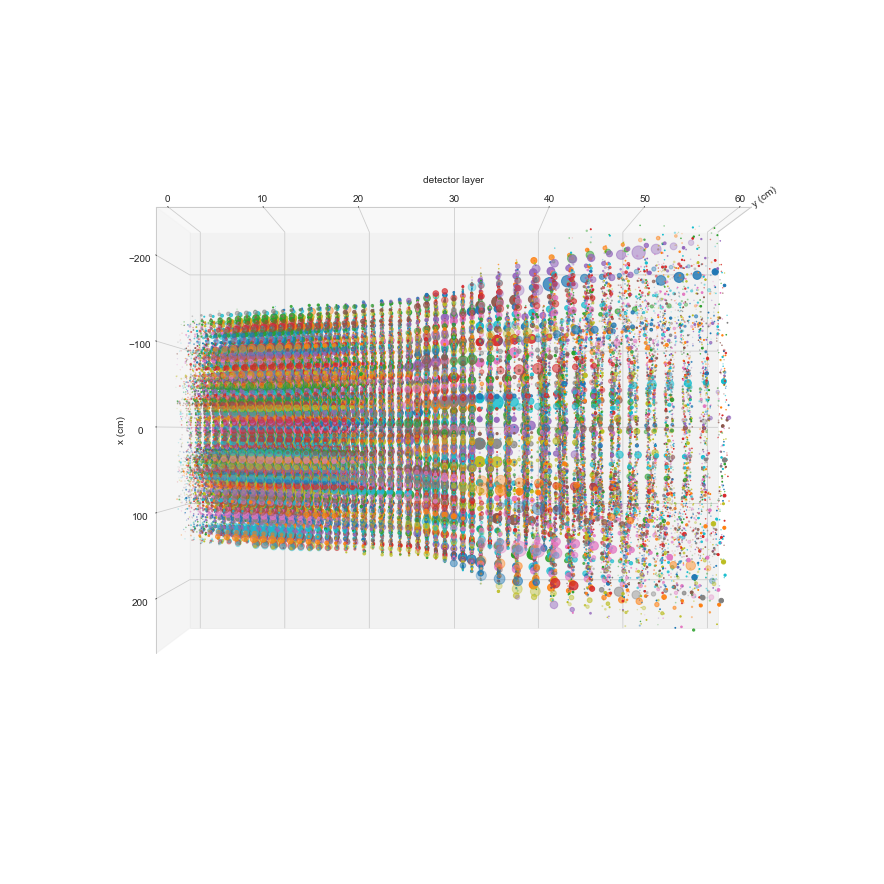

In [38]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_zlim(zlim)
ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
ax1.set_zlabel("detector layer")
# plt.axis('off')

for x, y, z, e in zip(vx, vy, vz, ve):
    ax1.scatter(x, y, z, s=e)

# ax1.set_title(f"Front view: reconstruction layer-clusters ({len(vx)})")
ax1.view_init(0, 180, "x")

ax1.get_yaxis().set_ticks([])
ax1.get_yaxis().set_visible(False)
